<font size=6>**Classical Statistics: Advanced Topics**</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize
from scipy.integrate import quad

import corner

%matplotlib inline

### Let's start with a simple example: Fitting a spectral line

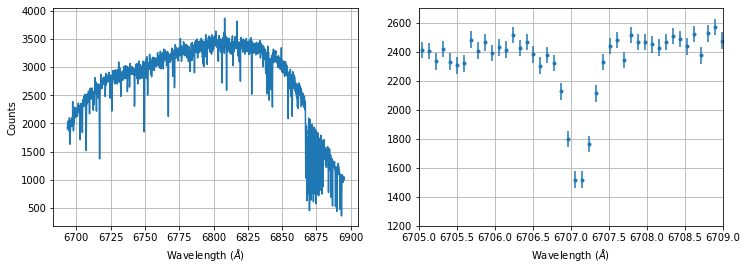

In [2]:
spectrum = np.load("data/lithium_line_example.npy")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(spectrum['wavelength'], spectrum['flux'])
ax[1].errorbar(spectrum['wavelength'], spectrum['flux'], yerr=spectrum['flux_error'], fmt='o', marker='.')

ax[1].set_xlim(6705, 6709)
ax[1].set_ylim(1200, 2700)

for a in ax:
    a.grid()

ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[1].set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Counts')

plt.show()

### Let's start by subtracting the continuum

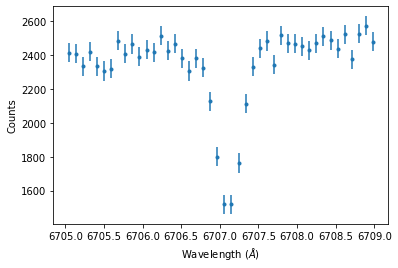

In [3]:
lithium_line = spectrum[spectrum['wavelength'] > 6705]
lithium_line = lithium_line[lithium_line['wavelength'] < 6709]


plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

### Let's start by describing our model: a linear continuum plus a Gaussian absorption feature

In [4]:
def model_flux(p, wavelength):
    """Return the flux for our model.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    wavelength : float
        The input wavelength(s) at which we wish to calculate our model
        
    Returns
    -------
    flux : float
        The model flux(es) calculated by our model
    """
    
    m, b, c, sigma, loc = p
    
    linear_part = m*(wavelength-6707) + b
    gaussian_part = -c * norm.pdf(wavelength, loc=loc, scale=sigma)
    
    return linear_part + gaussian_part

def ln_likelihood(p, data):
    """Return the likelihood of our model.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    data : ndarray
        The observed data from which we wish to calculate the likelihood of our model
        
    Returns
    -------
    ln_likelihood : float
        The log likelihood of our model
    """
    
    m, b, c, sigma, loc = p
    if sigma <= 0: return -np.inf
    if loc < 6706 or loc > 6708: return -np.inf
    
    # First, calculate the model fluxes at the observed wavelengths
    model_fluxes = model_flux(p, data['wavelength'])
    
    # Now capture our observed fluxes
    observed_fluxes = data['flux']
    observed_flux_errors = data['flux_error']
    
    # Compare the two
    ln_likelihood = -np.log(observed_flux_errors * np.sqrt(2*np.pi)) - (model_fluxes - observed_fluxes)**2 / (2 * observed_flux_errors**2)
        
    return sum(ln_likelihood)

def neg_ln_likelihood(p, data):
    """Wrapper for ln_likelihood to return the negative of the log likelihood.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    data : ndarray
        The observed data from which we wish to calculate the likelihood of our model
        
    Returns
    -------
    neg_ln_likelihood : float
        The negative of the log likelihood of our model
    """

    return -ln_likelihood(p, data)


### Let's start with a trial solution and use scipy minimize to find a solution

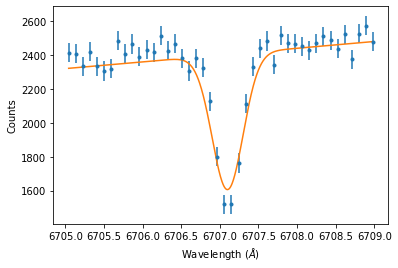

In [5]:
# m = 40
# b = -265800
m = 40
b = 2400
c = 400
sigma = 0.2
loc = 6707.1

p0 = m, b, c, sigma, loc

model_wavelengths = np.linspace(np.min(lithium_line['wavelength']), np.max(lithium_line['wavelength']), 1000)
model_fluxes = model_flux(p0, model_wavelengths)

plt.plot(model_wavelengths, model_fluxes, color='C1')

plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

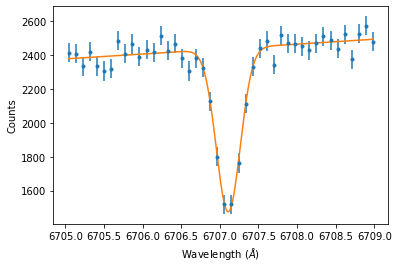

In [6]:
res = minimize(neg_ln_likelihood, p0, method='Nelder-Mead', args=lithium_line)

best_p = res.x
model_wavelengths = np.linspace(np.min(lithium_line['wavelength']), np.max(lithium_line['wavelength']), 1000)
model_fluxes = model_flux(best_p, model_wavelengths)

plt.plot(model_wavelengths, model_fluxes, color='C1')

plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

## Fisher Matrix

Now that we have a maximum likelihood estimate, how do we calculate the errors on our solution? After all, our solution is only as good as the error bars allow possible solutions. This is where a Fisher matrix can come in handy.

If the maximum likelihood is the point in parameter space where the derivative of the log likelihood function is equal to zero: 
$$\frac{\partial \log L(y_i | \theta)}{\partial \theta} = 0,$$

then the Fisher matrix is essentially the multi-variate form of the expectation value $E()$ of all the second derivatives of the log of the likelihood:

$$ F_{j,k} = 
    \begin{bmatrix} 
        -E\left[ \frac{\partial^2}{\partial \theta_1^2} \log L(y_i | \theta) \right] & -E\left[ \frac{\partial^2}{\partial \theta_1 \partial \theta_2} \log L(y_i | \theta) \right] & \dots & -E\left[ \frac{\partial^2}{\partial \theta_1 \partial \theta_N} \log L(y_i | \theta) \right] \\
        -E\left[ \frac{\partial^2}{\partial \theta_2 \partial \theta_1} \log L(y_i | \theta) \right] & -E\left[ \frac{\partial^2}{\partial \theta_2^2} \log L(y_i | \theta) \right] & \dots & -E\left[ \frac{\partial^2}{\partial \theta_2 \partial \theta_N} \log L(y_i | \theta) \right] \\
        \vdots & \vdots & \ddots & \vdots \\
        -E\left[ \frac{\partial^2}{\partial \theta_N \partial \theta_1} \log L(y_i | \theta) \right] & -E\left[ \frac{\partial^2}{\partial \theta_N \partial \theta_2} \log L(y_i | \theta) \right] & \dots & -E\left[ \frac{\partial^2}{\partial \theta_N^2} \log L(y_i | \theta) \right]
    \end{bmatrix}
$$

Now, assuming all the observations are Gaussian (we have already assumed they are in our likelihood function), these derivatives are reduced to a much nicer expression. First, we take the log of the likelihood.

$$ \log L(y_i | \theta) = -\frac{1}{2} \log 2 \pi - \frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [y_i - y(\lambda)]^2 $$

Now, we take the partial derivative with respect to our model parameter $\theta_i$:

$$ \frac{\partial}{\partial \theta_i} \log L(y_i | \theta) = - \frac{1}{\sigma^2} [y_i - y(\lambda)] \frac{\partial y(\lambda)}{\partial \theta_i} $$

Then, for any one element of the Fisher matrix, we have:

$$ -E\left[ \frac{\partial^2}{\partial \theta_j \partial \theta_k} \log L(y_i | \theta) \right] = E\left[ \frac{1}{\sigma^4} [y_i - y(\lambda)]^2 \frac{\partial y(\lambda)}{\partial \theta_j} \frac{\partial y(\lambda)}{\partial \theta_k} \right] $$

Since $E\left[[y_i - y(\lambda)]^2\right] = \sigma^2$, the individual matrix elements of the Fisher matrix can be represented as:

$$ F_{j,k} = \sum_{i=1}^N \frac{1}{\sigma^2} \frac{\partial y(\lambda)}{\partial \theta_j} \frac{\partial y(\lambda)}{\partial \theta_k} $$

### One more thing - calculating numerical derivatives
To do that, we need to calculate numerical derivatives. A simple way to do that is to calculate the value of $y(\lambda | \theta_i)$ and $y(\lambda | \theta_i+\delta)$. The difference in the two values divided by the difference in the model parameter gives a numerical derivative:

$$ \frac{\partial y(\lambda)}{\partial \theta_j} = \frac{y(\lambda | \theta + \delta) - y(\lambda | \theta)}{(\theta + \delta) - \theta} = \frac{y(\lambda | \theta + \delta) - y(\lambda | \theta)}{\delta} $$

### Now, we can code it up


In [7]:
from copy import deepcopy

def calc_fisher_matrix(data, best_p, delta_p=1e-5):

    N = len(best_p)
    
    # Create the Fisher matrix
    F = np.zeros((N, N))

    
    # Now we calculate the numerical derivatives with our five model parameters    
    for i in range(N):
        
        # Add the delta to the theta_i model parameter
        test_p_i = deepcopy(best_p)
        test_p_i[i] += delta_p*best_p[i]
        
        # Calculate the difference in the resulting model fluxes
        test_flux = model_flux(test_p_i, data['wavelength'])
        delta_flux = test_flux - data['flux']    
        
        # Now, we can calculate our derivatives
        derivs_i = delta_flux / (delta_p*best_p[i])
        
        # Repeat the same calculation as above for each of the j model parameters
        for j in range(N):
            test_p_j = deepcopy(best_p)
            test_p_j[j] += delta_p*best_p[j]

            test_flux = model_flux(test_p_j, data['wavelength'])
            delta_flux = test_flux - data['flux']    
            derivs_j = delta_flux / (delta_p*best_p[j])
            
            # Now we can put these together to calculate the Fisher matrix
            F[i,j] = sum(1/data['flux_error']**2 * derivs_i * derivs_j)
    
            
    return F

In [8]:
F = calc_fisher_matrix(lithium_line, best_p)

for i in range(len(best_p)):
    print(F[i])


[3.97648120e+08 4.74218099e+06 3.08585736e+07 7.45143241e+10
 1.72932752e+06]
[4.74218099e+06 5.65532312e+04 3.68006115e+05 8.88625883e+08
 2.06232339e+04]
[3.08585736e+07 3.68006115e+05 2.39470909e+06 5.78251383e+09
 1.34199017e+05]
[7.45143241e+10 8.88625883e+08 5.78251383e+09 1.39630599e+13
 3.24060443e+08]
[1.72932752e+06 2.06232339e+04 1.34199017e+05 3.24060443e+08
 2.52982995e+04]


### Before we proceed, a side note on numerical derivatives

There are fancier methods, but we are just using a simple finite difference scheme. However, its accuracy depends on the $\delta$ we use: too large and the model starts to change (i.e., adding a $\delta$ moves us significantly away from the maximum likelihood point) and too small and we run into numerical difficulties in calculating small numbers. 

Our default value in the function we wrote above is $10^-5$. Let's see if that's a good value. We can do this by testing a wide range of $\delta$ values, across a large dynamical range. Since we don't have a sense a priori of what the correct scale is, we will recalculate the diagonal elements of the Fisher matrix over a logarithmic range of $\delta$'s.

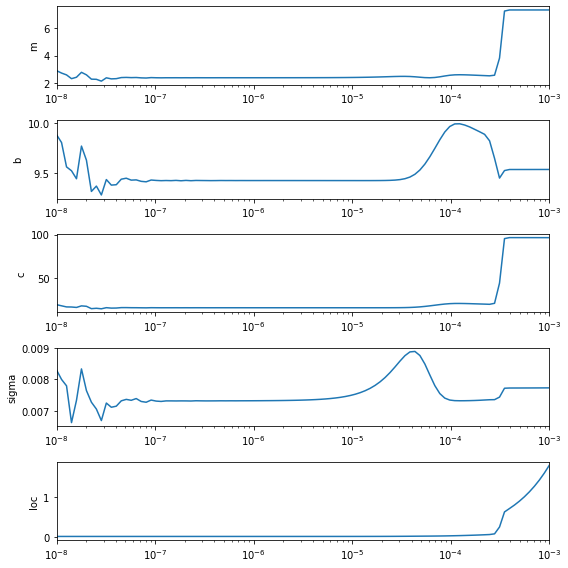

In [9]:
delta_p_set = np.logspace(-8, -3, 100)

sigma_m = np.zeros(len(delta_p_set))

fig, ax = plt.subplots(5, 1, figsize=(8, 8))


labels = ['m', 'b', 'c', 'sigma', 'loc']

for j in range(len(best_p)):
    for i, delta_p in enumerate(delta_p_set):

        F = calc_fisher_matrix(lithium_line, best_p, delta_p=delta_p)
        test_new_matrix = np.mat(F).I
        sigma_m[i] = np.sqrt(test_new_matrix[j,j])

    ax[j].plot(delta_p_set, sigma_m)
    
    ax[j].set_xscale('log')

    ax[j].set_xlim(1e-8, 1e-3)
    ax[j].set_ylabel(labels[j])

plt.tight_layout()
    
plt.show()

Clearly things start to become strange at very small $\delta$ of $10^{-8}$ and again at a very large $\delta$ of $10^{-4}$. Somewhere in the middle, the parameters seem converged. $10^{-5}$ is reasonable, but we could probably go lower to $10^{-6}$ if we wanted to really focus on accuracy.

### Covariance matrix

So, why is the Fisher matrix so valuable? Let's return to our original question: how do we calculate the error bars on our maximum likelihood estimate? It turns out that the inverse of the Fisher matrix is the covariance matrix:

$$ F_{j,k}^{-1} = {\rm cov} =
    \begin{bmatrix} 
        \sigma_{\theta_1}^2 & \sigma_{\theta_1} \sigma_{\theta_2} & \dots & \sigma_{\theta_1} \sigma_{\theta_N} \\
        \sigma_{\theta_2} \sigma_{\theta_1} & \sigma_{\theta_2}^2 & \dots & \sigma_{\theta_2} \sigma_{\theta_N} \\
        \vdots & \vdots & \ddots & \vdots \\
        \sigma_{\theta_N} \sigma_{\theta_1} & \sigma_{\theta_N} \sigma_{\theta_2} & \dots & \sigma_{\theta_N}^2
    \end{bmatrix}
$$


Diagonal matrices of the standard deviations can be factored out:
$$ {\rm cov} = 
    \begin{bmatrix} 
        \sigma_{\theta_1} &  &  & 0 \\
         & \sigma_{\theta_2} &  &  \\
         &  & \ddots &  \\
        0 &  &  & \sigma_{\theta_N}
    \end{bmatrix}   
    \begin{bmatrix} 
        1 & \rho_{\theta_1, \theta_2} & \dots & \rho_{\theta_1, \theta_N} \\
        \rho_{\theta_2, \theta_1} & 1 & \dots & \rho_{\theta_2, \theta_N} \\
        \vdots & \vdots & \ddots & \vdots \\
        \rho_{\theta_N, \theta_1} & \rho_{\theta_N, \theta_2}  & \dots & 1
    \end{bmatrix}
    \begin{bmatrix} 
        \sigma_{\theta_1} &  &  & 0 \\
         & \sigma_{\theta_2} &  &  \\
         &  & \ddots &  \\
        0 &  &  & \sigma_{\theta_N}
    \end{bmatrix}
$$

The off-diagonal terms of the middle matrix (the correlation matrix) are the same Pearson correlation coefficients you have already seen. 

### So, how can we visualize the correlation matrix?

There are a few ways, but we can take a simple approach: Let's start by generating lots of samples based on the covariance matrix, then use Dan Foreman-Mackey's `corner` package to plot it.


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


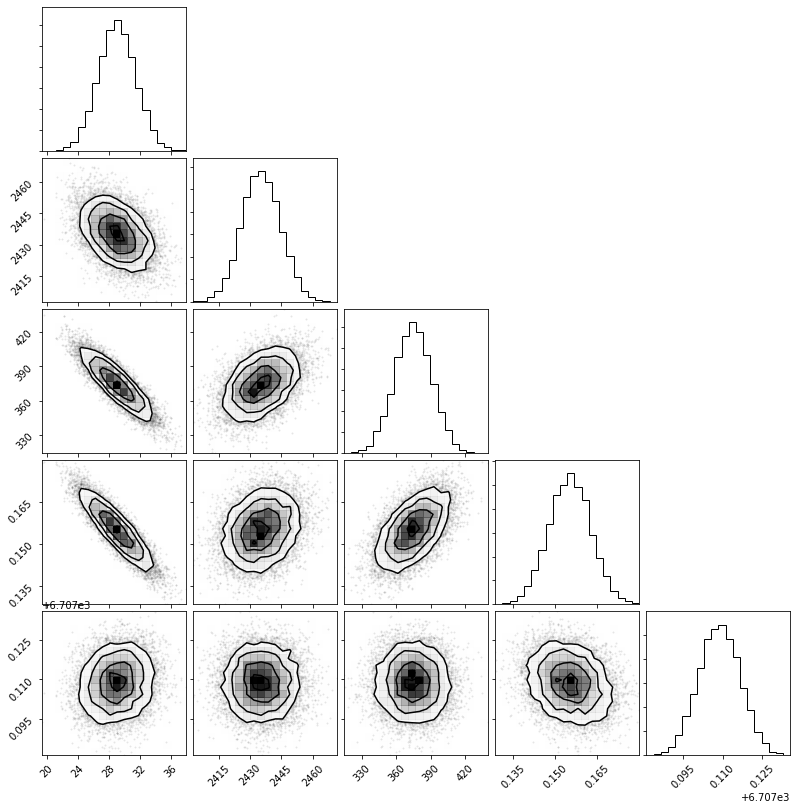

In [10]:
# Start by re-generating the covariance matrix
F = calc_fisher_matrix(lithium_line, best_p)
cov = np.mat(F).I

# We also need a set of "mean" values, in this case, the maximum likelihood
mean = best_p

# Generate the samples using the rvs method (rvs = random variates)
samples = multivariate_normal.rvs(mean, cov, size=10000)

# Use DFM's corner package
corner.corner(samples)

plt.show()

## How to interpret our results?

For one thing, we find that a few parameters are showing significant correlations. For instance the slope of the continuum ($m$) is correlated with the depth ($c$) and width ($\sigma$) of the Gaussian absorption feature.


Next, we can check, do these results seem reasonable? One way to check this is to plot a bunch of results against the data. Note, this is also an excellent way of demonstrating the model fit along with its uncertainty in a publication

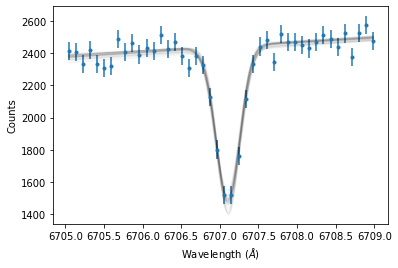

In [11]:
model_wavelengths = np.linspace(np.min(lithium_line['wavelength']), np.max(lithium_line['wavelength']), 1000)

# Let's take the first 20 samples and plot them
for sample in samples[:20]:

    model_fluxes = model_flux(sample, model_wavelengths)

    plt.plot(model_wavelengths, model_fluxes, color='k', alpha=0.05)

# Now, compare against the data
plt.errorbar(lithium_line['wavelength'], lithium_line['flux'], 
             yerr=lithium_line['flux_error'], 
             fmt='o', marker='.')

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')

plt.show()

## Monte Carlo Error Propagation

What we've unwittingly done is Monte Carlo error propagation: we've visually expressed the set of reasonable model solutions in a statistically meaningful way. If we want to quantitatively propagate errors, we can follow the same procedure. 


### Equivalent width

Let's take a simple example: calculating the equivalent width of the lithium absorption feature. When one goes to compare the spectral feature against a stellar atmospheric model to calculate a lithium abundance, one uses the "equivalent width" of the feature rather than the raw data. Mathematically, an equivalent width $W$ can be calculated by integrating the fractional difference between the continuum flux $F_c$ and the line flux $F_s$:

$$ W_{\lambda} = \int \frac{F_c - F_s}{F_c}\ {\rm d}\lambda = \int 1 - \frac{F_s}{F_c}\ {\rm d}\lambda $$

However, things get a little tricky since our continuum isn't normalized. So let's take care of that first. If we normalize our spectrum so the continuum is at unity, and the Gaussian feature along with it, then the equivalent width calculation is simply:

$$ W_{\lambda} = \int F_s^*\ {\rm d}\lambda $$

Since it's a Gaussian, the integral could be computed analytically. However, just to demonstrate how this is done for an arbitrarily complex function, we'll use a numerical integration.

Let's code it up!

In [12]:
def calc_equivalent_width_integrand(wavelength, p):
    """Return the flux for our model.
    
    Arguments
    ---------
    p : tuple
        The model parameters
    wavelength : float
        The input wavelength(s) at which we wish to calculate our model
        
    Returns
    -------
    flux : float
        The model flux(es) calculated by our model
    """
    
    m, b, c, sigma, loc = p
    
    linear_part = m*(wavelength-6707) + b
    gaussian_part = -c * norm.pdf(wavelength, loc=loc, scale=sigma)

    # Normalize Gaussian depth to line center
    c_normed = c / (m*(loc-6707) + b)
    
    # Normalized Gaussian
    normed_gaussian = c_normed * norm.pdf(wavelength, loc=loc, scale=sigma)
    
    return normed_gaussian

Now, we can follow the same process as before: We generate a number of model parameter samples based on our maximum likelihood estimate and covariance matrix (in this case we use the samples we already generated) and separately calculate the equivalent width for each of those samples. Since the numerical integration is a somewhat expensive operation, we only need calculate the equivalent widht of a thousand or so samples to derive our estimate of the equivalent width.

We'll use `Scipy`'s `quad` routine to calculate the integral. This function requires bounds on the integral, which we want to make large enough to capture the entire line. In this case, we'll use 6706 Ang to 6708 Ang.

In [13]:

res = []
for p in samples[0:1000]:
    res.append(quad(calc_equivalent_width_integrand, 6706, 6708, p)[0])


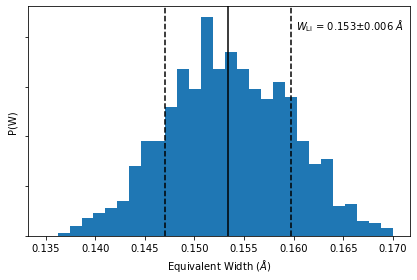

In [14]:
bins = np.linspace(0.135, 0.170, 30)
plt.hist(res, bins=bins)

plt.axvline(np.mean(res), color='k')
plt.axvline(np.mean(res) - np.std(res), color='k', linestyle='dashed')
plt.axvline(np.mean(res) + np.std(res), color='k', linestyle='dashed')

plt.xlabel(r'Equivalent Width ($\AA$)')
plt.ylabel('P(W)')

plt.text(0.7, 0.9, r'$W_{\rm Li}$ = %.3f$\pm$%.3f $\AA$'%(np.mean(res), np.std(res)),
         transform=plt.gca().transAxes)

plt.gca().set_yticklabels([])

plt.tight_layout()
plt.show()

### What have we learned? 

We have derived an equivalent width of 0.153 +/- 0.006 angstroms. The key here is that not only do we have a measurement for the equivalent width, but we have derived error bars for it as well! These error bars were propagated from the model we derived for the lithium line, including the covariances.

## With your partner, discuss the Fisher Information

Returning to the Fisher matrix, the diagonal elements are called the "Fisher Information", $F(\theta)$. Note the dependence on $\theta$, as each parameter in a model will have a different Fisher Information. Spend a few minutes with your partner discussing the these diagonal elements. Use its relation with the covariance matrix to try and get a sense of what a large Fisher Information means about a parameter and what a small Fisher Information means about a parameter.

# Workshop 1: calculate the equivalent widths of lithium in other stars

In [15]:
spectrum_1 = np.load("data/lithium_line_test_1.npy")
spectrum_2 = np.load("data/lithium_line_test_2.npy")
spectrum_3 = np.load("data/lithium_line_test_3.npy")

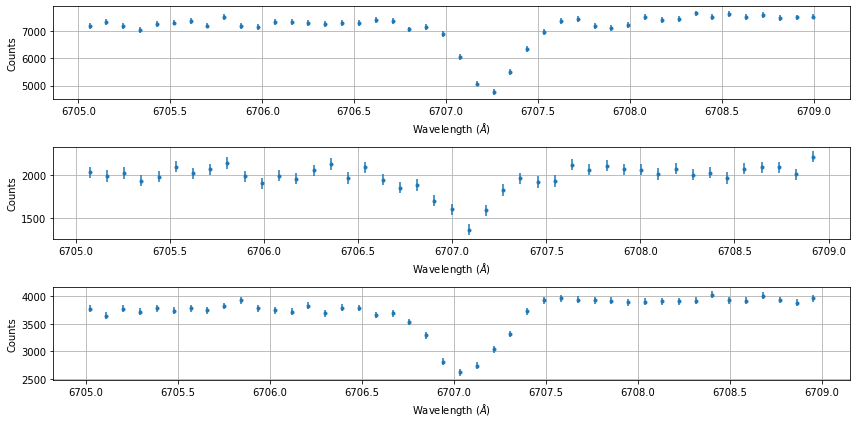

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))


for i, spectrum in enumerate([spectrum_1, spectrum_2, spectrum_3]):

    lithium_line = spectrum[spectrum['wavelength'] > 6705]
    lithium_line = lithium_line[lithium_line['wavelength'] < 6709]


    ax[i].errorbar(lithium_line['wavelength'], lithium_line['flux'], 
                   yerr=lithium_line['flux_error'], 
                   fmt='o', marker='.')

for a in ax:
    a.set_xlabel(r'Wavelength ($\AA$)')
    a.set_ylabel('Counts')

    a.grid()
    
plt.tight_layout()
plt.show()

# Workshop 2: calculate the equivalent other lines in the example star